In [1]:
using ProgressMeter
using ITensors
using RandomMeas

In [6]:
N = 2
depth = 5
ξ = siteinds("Qubit", N)
circuit    = RandomCircuit(ξ,depth)
states = ["Dn" for n in 1:N]
cutoff = 1e-4
ψ0 = MPS(ξ,states);
ρ0 = outer(ψ0',ψ0);
ρ1 = apply(circuit,ρ0,apply_dag=true);
p = 0.03*rand(N)
ψ = Vector{MPS}()
ρ = Vector{MPO}()
@showprogress dt=1 for d in 1:depth
        if d==1
            push!(ψ,apply(circuit,ψ0;cutoff=cutoff))
            ρt = apply(circuit,ρ0,apply_dag=true;cutoff=cutoff)
            ρt = Apply_depo_channel(ρt,p)
            push!(ρ,ρt);
        else
            push!(ψ,apply(circuit,ψ[d-1];cutoff=cutoff))
            ρt = apply(circuit,ρ[d-1],apply_dag=true;cutoff=cutoff)
            ρt = Apply_depo_channel(ρt,p)
            push!(ρ,ρt);  
        end
end

println("state prepared in the `experiment")
println(maxlinkdim(ψ[depth]))
println(maxlinkdim(ρ[depth]))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


state prepared in the `experiment
2
4


In [7]:
#Perform Randomized measurements
nu=100
NM=10000
Fs = zeros(Float64,depth)
FsCRM = zeros(Float64,depth)
for d in 1:depth
    data = [zeros(Int8,(NM,N)) for r in 1:nu]
    u = Vector{Vector{ITensor}}()
    P = Vector{ITensor}()
    P0 = Vector{ITensor}()
    @showprogress dt=1 for r in 1:nu
                    push!(u,get_rotations(ξ,1)) #Haar rotations in A
                    data[r] = get_RandomMeas(ρ[d],u[r],NM)
                    push!(P,get_Born(data[r],ξ))
                    ψu = apply(u[r],ψ[d])
                    push!(P0,get_Born(ψu))
                    Fs[d] += get_overlap(P[r],P0[r],ξ,N)/nu
                    FsCRM[d] += (get_overlap(P[r],P0[r],ξ,N)-get_overlap(P0[r],P0[r],ξ,N)+1)/nu
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [8]:
#Fidelity
F = [real(inner(ψ[d]',ρ[d],ψ[d])) for d in 1:depth];
@show F;

F = [0.9701271698033077, 0.9406726673422098, 0.9066406789376849, 0.8792777333232729, 0.8494634860822206]


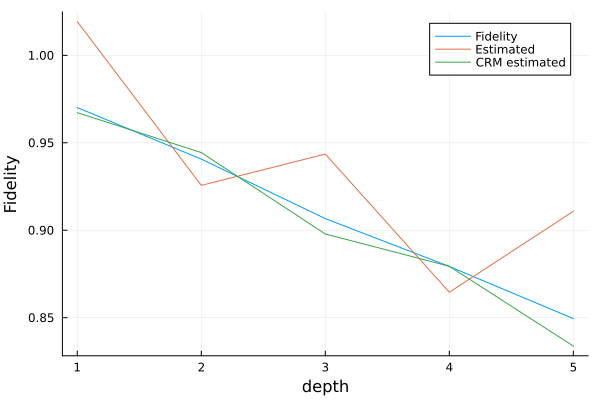

In [9]:
using Plots
Plots.plot(1:depth,F,label="Fidelity")
plot!(1:depth,Fs,label="Estimated")
plot!(1:depth,FsCRM,label="CRM estimated")
xlabel!("depth")
ylabel!("Fidelity")